<a href="https://colab.research.google.com/github/kushalsubedi/NEPSE_StockData/blob/main/lstm-final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries Import

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt


In [14]:
file_path = '/NABIL.csv'
df = pd.read_csv(file_path)
df

,sn,Date,Close,Change,High,Low,Open,Volume,Value
0,1,2024/03/14,471.90,-0.23,480.00,468.30,480.00,"48,287","22,778,295.10"
1,2,2024/03/13,473.00,0.85,479.90,467.00,477.00,"66,733","31,614,147.30"
2,3,2024/03/12,469.00,4.27,470.00,455.00,458.70,"62,909","29,076,699.00"
3,4,2024/03/10,449.80,0.97,451.00,447.00,448.00,"38,263","17,184,098.60"
4,5,2024/03/07,445.50,0.79,450.00,442.00,450.00,"27,778","12,360,332.50"
...,...,...,...,...,...,...,...,...,...
2176,2185,2014/08/04,"2,571.00",-0.35,"2,612.00","2,565.00","2,580.00","2,070","4,782,158.00"
2177,2186,2014/08/04,"2,583.00",0.47,"2,600.00","2,575.00","2,571.00","2,243","4,782,158.00"
2178,2187,2014/08/04,"2,600.00",-1.96,"2,620.00","2,600.00","2,652.00",856,"4,782,158.00"
2179,2188,2014/08/04,"2,610.00",0.38,"2,610.00","2,560.00","2,600.00",281,"4,782,158.00"


In [15]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [36]:
df
df = df.dropna()
df.tail()

,sn,Close,Change,High,Low,Open,Volume,Value
Date,,,,,,,,
2014-08-04,2185,"2,571.00",-0.35,"2,612.00","2,565.00",2580.0,"2,070","4,782,158.00"
2014-08-04,2186,"2,583.00",0.47,"2,600.00","2,575.00",2571.0,"2,243","4,782,158.00"
2014-08-04,2187,"2,600.00",-1.96,"2,620.00","2,600.00",2652.0,856,"4,782,158.00"
2014-08-04,2188,"2,610.00",0.38,"2,610.00","2,560.00",2600.0,281,"4,782,158.00"
2014-08-04,2189,"2,580.00",-1.15,"2,610.00","2,576.00",2610.0,"1,885","4,782,158.00"


In [22]:
scaler = MinMaxScaler()
df['Open'] = df['Open'].str.replace(',', '').astype(float)
df_scaled = scaler.fit_transform(df[['Open']])

In [23]:
# prompt: document the following function

def create_dataset(df_scaled, look_back=1):
  x_train = []
  y_train = []
  for i in range(len(df_scaled) - look_back):
    x_train.append(df_scaled[i:i + look_back])
    y_train.append(df_scaled[i + look_back])
  return x_train, y_train


In [25]:
sequence_length = 10
X, y = create_dataset(df_scaled, sequence_length)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [26]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

### LSTM Model

The Long Short-Term Memory (LSTM) model is a type of recurrent neural network (RNN) architecture that is capable of learning long-term dependencies. It consists of multiple LSTM units, each with a memory cell and various gates to control the flow of information.

The mathematical formulation of an LSTM unit can be represented as follows:

\
\begin{align*}
i_t &= \sigma(W_{xi}x_t + W_{hi}h_{t-1} + W_{ci}c_{t-1} + b_i) \\
f_t &= \sigma(W_{xf}x_t + W_{hf}h_{t-1} + W_{cf}c_{t-1} + b_f) \\
g_t &= \text{tanh}(W_{xg}x_t + W_{hg}h_{t-1} + b_g) \\
o_t &= \sigma(W_{xo}x_t + W_{ho}h_{t-1} + W_{co}c_{t-1} + b_o) \\
c_t &= f_t \odot c_{t-1} + i_t \odot g_t \\
h_t &= o_t \odot \text{tanh}(c_t)
\end{align*}


Where:
- \(x_t\) is the input at time step \(t\),
- \(h_t\) is the hidden state at time step \(t\),
- \(c_t\) is the cell state at time step \(t\),
- \(i_t\), \(f_t\), \(g_t\), and \(o_t\) are the input, forget, cell, and output gates, respectively,
- \(W\) and \(b\) are the weight matrices and bias vectors,
- \(\sigma\) is the sigmoid activation function, and
- \(\odot\) denotes element-wise multiplication.

In this formulation:
- The input gate \(i_t\) controls how much new information is allowed to enter the memory cell \(c_t\).
- The forget gate \(f_t\) controls how much of the previous cell state \(c_{t-1}\) should be forgotten.
- The cell gate \(g_t\) computes the new candidate values that could be added to the cell state.
- The output gate \(o_t\) controls how much of the cell state \(c_t\) should be exposed to the outside world.

LSTM networks are widely used in sequence prediction tasks due to their ability to effectively capture and remember long-term dependencies in the input sequences.


In [27]:
model = Sequential()
model.add(LSTM(50, activation='sigmoid', return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(50, activation='sigmoid'))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [28]:
# Convert lists to arrays and reshape for LSTM input
X_train = np.array(X_train).reshape((len(X_train), sequence_length, 1))
X_test = np.array(X_test).reshape((len(X_test), sequence_length, 1))


In [101]:
y_train = np.array(y_train).reshape((len(y_train), 1))
y_test = np.array(y_test).reshape((len(y_test), 1))
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), verbose=2)


Epoch 1/100
28/28 - 1s - loss: 2.4564e-04 - val_loss: 5.5734e-04 - 799ms/epoch - 29ms/step
Epoch 2/100
28/28 - 0s - loss: 2.3466e-04 - val_loss: 5.9382e-04 - 473ms/epoch - 17ms/step
Epoch 3/100
28/28 - 0s - loss: 2.3275e-04 - val_loss: 5.3113e-04 - 450ms/epoch - 16ms/step
Epoch 4/100
28/28 - 0s - loss: 2.1841e-04 - val_loss: 5.4590e-04 - 443ms/epoch - 16ms/step
Epoch 5/100
28/28 - 0s - loss: 2.4803e-04 - val_loss: 5.2391e-04 - 441ms/epoch - 16ms/step
Epoch 6/100
28/28 - 0s - loss: 2.1355e-04 - val_loss: 5.2019e-04 - 438ms/epoch - 16ms/step
Epoch 7/100
28/28 - 0s - loss: 2.3035e-04 - val_loss: 9.6283e-04 - 452ms/epoch - 16ms/step
Epoch 8/100
28/28 - 0s - loss: 2.9726e-04 - val_loss: 6.9548e-04 - 475ms/epoch - 17ms/step
Epoch 9/100
28/28 - 0s - loss: 2.3865e-04 - val_loss: 5.6569e-04 - 456ms/epoch - 16ms/step
Epoch 10/100
28/28 - 0s - loss: 2.1918e-04 - val_loss: 5.5371e-04 - 450ms/epoch - 16ms/step
Epoch 11/100
28/28 - 0s - loss: 2.2649e-04 - val_loss: 5.1890e-04 - 431ms/epoch - 15ms/st

In [102]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

14/14 [==============================] - 0s 5ms/step


In [103]:
# Inverse transform the predictions to the original scale
train_predictions = scaler.inverse_transform(train_predictions)
y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1))

test_predictions = scaler.inverse_transform(test_predictions)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))



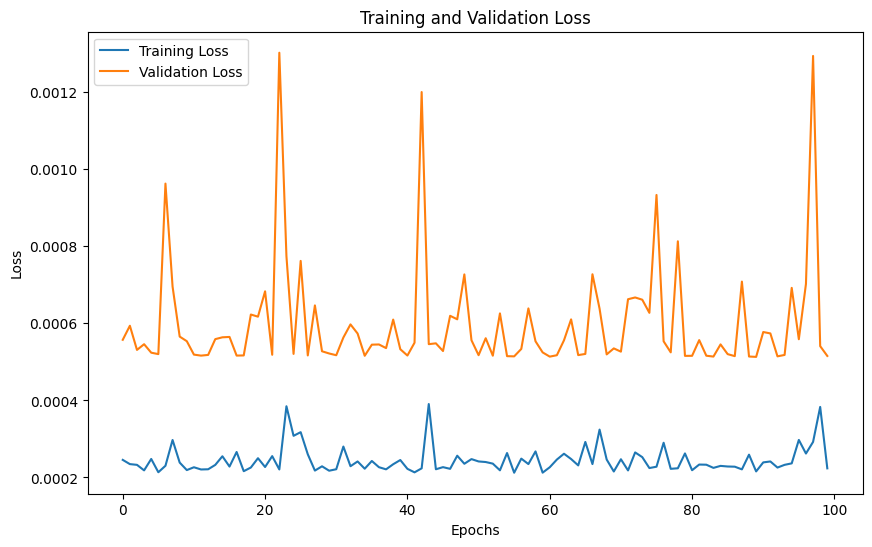

In [104]:
plt.figure(figsize=(10, 6))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


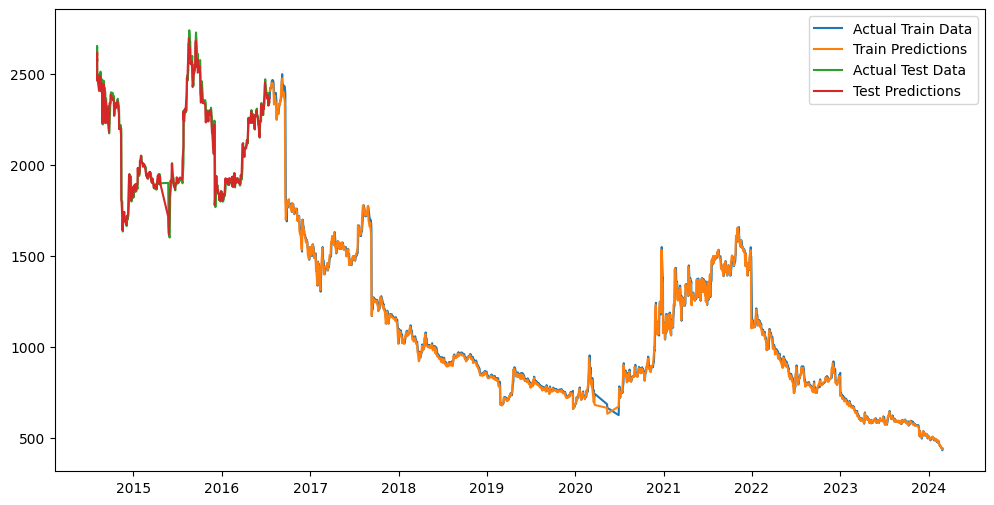

In [105]:
# Plot the results
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(df.index[sequence_length:sequence_length+train_size], y_train_original, label='Actual Train Data')
plt.plot(df.index[sequence_length:sequence_length+train_size], train_predictions, label='Train Predictions')
# Plot testing data
test_index = df.index[sequence_length + train_size:sequence_length + train_size + len(test_predictions)]
plt.plot(test_index, y_test_original, label='Actual Test Data')
plt.plot(test_index, test_predictions, label='Test Predictions')

plt.legend()
plt.show()


In [106]:
df = df.sort_index(ascending=False)

# Scale the most recent data
latest_data = df.head(sequence_length)
latest_scaled = scaler.transform(latest_data[['Open']])

# Reshape the scaled data
latest_scaled = np.array(latest_scaled).reshape((1, sequence_length, 1))

# Predict tomorrow's price
tomorrow_prediction = model.predict(latest_scaled)
tomorrow_prediction = scaler.inverse_transform(tomorrow_prediction)

print("Tomorrow's predicted price:", tomorrow_prediction[0])

1/1 [==============================] - 0s 29ms/step
Tomorrow's predicted price: [442.4238]




# Evaluation Metrics
**Confusion Matrix** <br>
A confusion matrix is a performance measurement for classification algorithms. It summarizes the correct and incorrect predictions made by a classifier. The confusion matrix is organized into four quadrants: true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN). These values can be used to calculate various evaluation metrics such as accuracy, precision, recall, and F1 score.

**Evaluation Metrics** <br>
- Accuracy: Measures the proportion of correctly classified instances.
- Precision: Measures the proportion of true positive predictions among all positive predictions.
- Recall: Measures the proportion of true positive predictions among all actual positives.
- F1 Score: Harmonic mean of precision and recall, provides a balance between them.



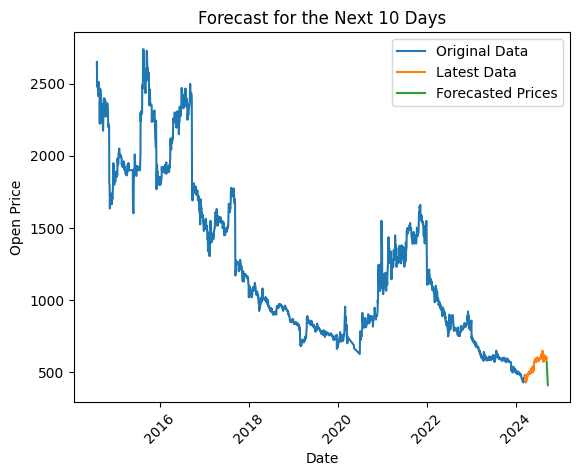

In [107]:
# Define the number of days to consider for forecasting
n_days_to_consider = 180

# Use the first 100 days of data for forecasting
latest_data = df_scaled[:n_days_to_consider]

# Initialize temp_input with the latest data
temp_input = list(latest_data.reshape(-1))

lst_output = []

# Generating the forecast for the next 10 days
for i in range(10):
    if len(temp_input) > n_days_to_consider:
        x_input = np.array(temp_input[1:]).reshape(1, -1)
        x_input = x_input.reshape((1, n_days_to_consider, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, len(temp_input), 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())

# Inverse transform the forecasted values
forecast_inv = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))

# Generate arrays for plotting
latest_dates = pd.date_range(start=df.index[0], periods=n_days_to_consider)  # Dates for the latest data
forecast_dates = pd.date_range(start=latest_dates[-1] + pd.Timedelta(days=1), periods=10)  # Dates for the forecast

# Plotting
plt.plot(df.index, df['Open'], label='Original Data')
plt.plot(latest_dates, scaler.inverse_transform(latest_data), label='Latest Data')
plt.plot(forecast_dates, forecast_inv, label='Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Forecast for the Next 10 Days')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


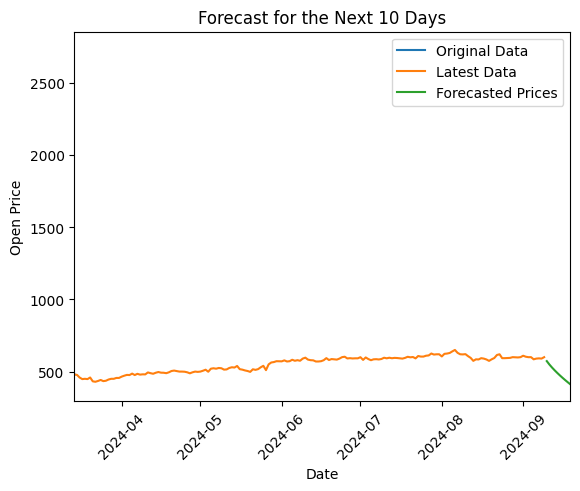

In [108]:
# Plotting
plt.plot(df.index, df['Open'], label='Original Data')
plt.plot(latest_dates, scaler.inverse_transform(latest_data), label='Latest Data')
plt.plot(forecast_dates, forecast_inv, label='Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Forecast for the Next 10 Days')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Expand the x-axis limits
plt.xlim(df.index[0], forecast_dates[-1])

plt.show()